In [1]:
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set_style('darkgrid')

from tqdm import tqdm_notebook as tqdm

from utils import show_single_frame, show_multiply_frames, get_frames, draw_rois

### Load images

In [2]:
frames, gray_frames = get_frames('./data/ellipse/')
frame = frames[0]
gray_frame = gray_frames[0]

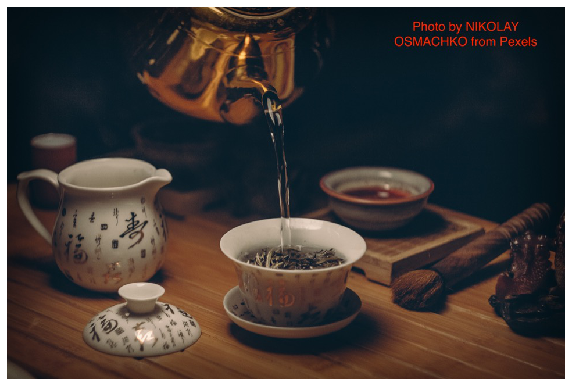

In [3]:
show_single_frame(frame, '')

### Code for finding ellipses

In [5]:
def get_ellipse(points):
    matrix = []
    for point in points:
        matrix.append([point[0]**2, 2 * point[0] * point[1], point[1]**2, 2 * point[0], 2 * point[1], 1])

    matrix = np.array(matrix, dtype=np.double)
    matrix = matrix.transpose().dot(matrix)

    u, s, v = np.linalg.svd(matrix)

    r = v[-1, :]
    r /= r[0]
    e = np.array([[r[0], r[1], r[3]],
                  [r[1], r[2], r[4]],
                  [r[3], r[4], r[5]]], np.double)
    
    return e

def draw_ellipse(frame, e, num_points, init_points):
    u, s, v = np.linalg.svd(e)
    h = np.linalg.inv(np.diag(np.sqrt(s)).dot(u.transpose()))

    angles = np.linspace(0, 2 * np.pi, num=num_points)

    points = []
    prev_point = None
    for i, angle in enumerate(angles):
        ellipse_point = h.dot(np.array([np.sin(angle), np.cos(angle), 1.0]))
        ellipse_point = ellipse_point[:2] / ellipse_point[2]
        ellipse_point = tuple(ellipse_point.astype(int))
        if prev_point:
            frame = cv2.line(frame, prev_point, ellipse_point, (0, 255, 0), 4)
        prev_point = ellipse_point
        points.append(ellipse_point)
    points = np.array(points)
        
    for point in init_points:
        frame = cv2.circle(frame, tuple(point.astype(int)), 3, (0, 0, 255), 4)

    return frame, points


In [6]:
points = np.array([[366, 407], [513, 363], [377, 426], [486, 456], [565, 449],
                    [592, 439], [617, 408], [417, 371], [567,372]], np.double)

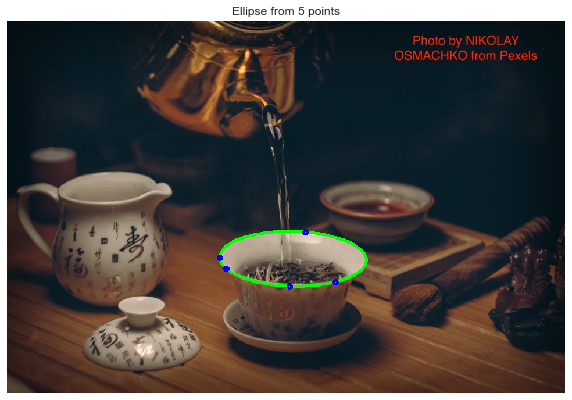

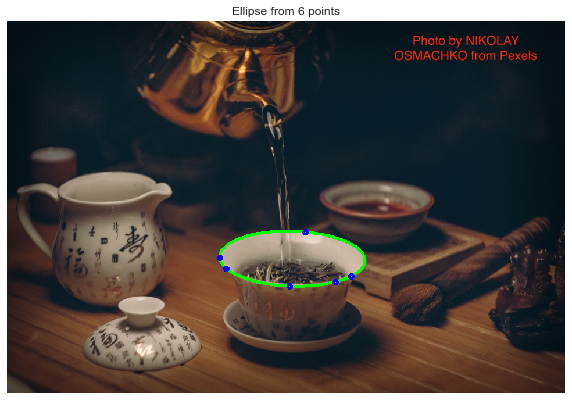

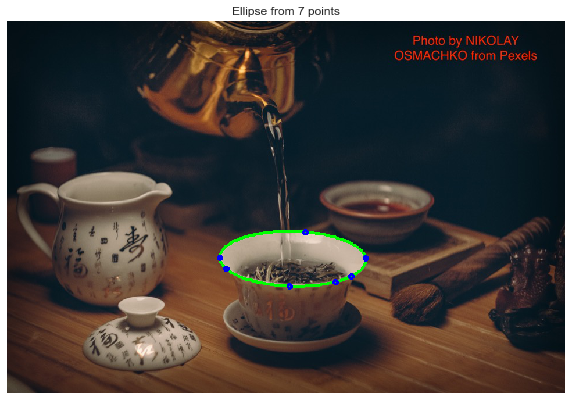

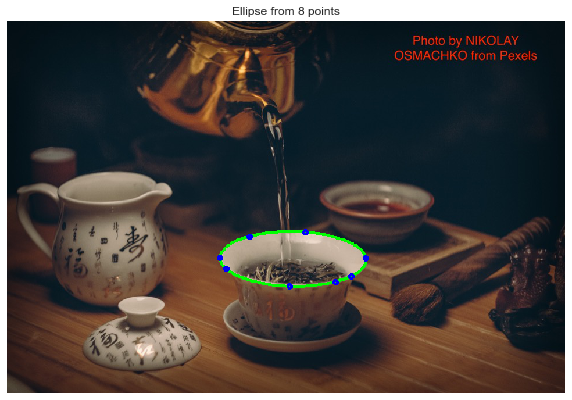

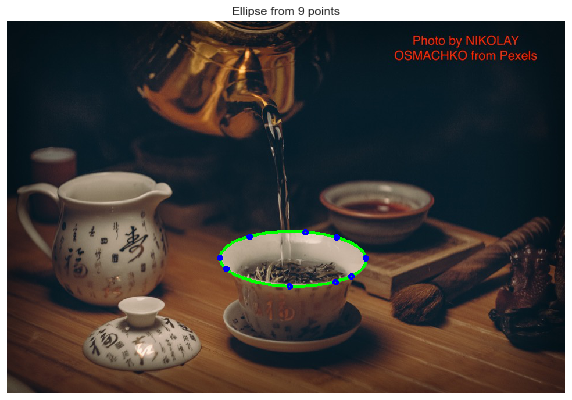

In [7]:
for num_points in range(5, 10):
    e = get_ellipse(points[:num_points])
    frame_, points_ = draw_ellipse(frame.copy(), e, 200, points[:num_points])
    show_single_frame(frame_, 'Ellipse from {} points'.format(num_points))

### Stability check

In [49]:
differences = []
for num_points in tqdm(range(5, 10)):
    interesting_points = points[:num_points]
    e = get_ellipse(interesting_points)
    frame_, ellipse_points = draw_ellipse(frame.copy(), e, 200, interesting_points)
    
    differences_ = []
    for sigma in np.arange(0, 5, 0.1):
        difference = 0
        for n in range(50):
            noised_points = interesting_points + sigma*np.random.randn(*interesting_points.shape)
            e = get_ellipse(noised_points)
            frame_, noised_ellipse_points = draw_ellipse(frame.copy(), e, 200, noised_points)

            difference += np.mean((ellipse_points - noised_ellipse_points)**2)
            difference /= 50
        
        differences_.append(np.log(difference))
    
    differences.append(differences_)
    

/Users/ai/Soft/anaconda3/envs/ds/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


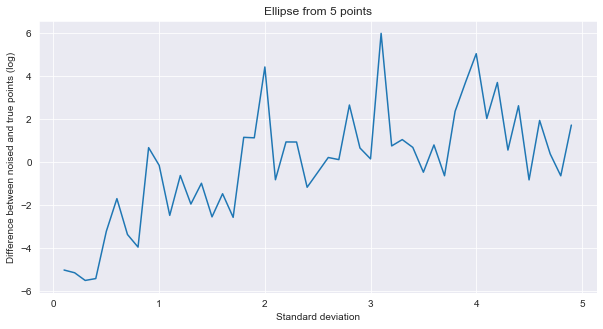

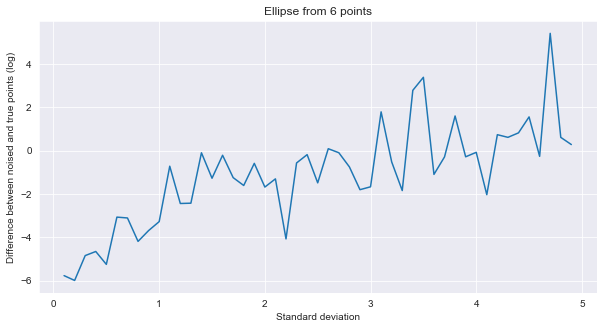

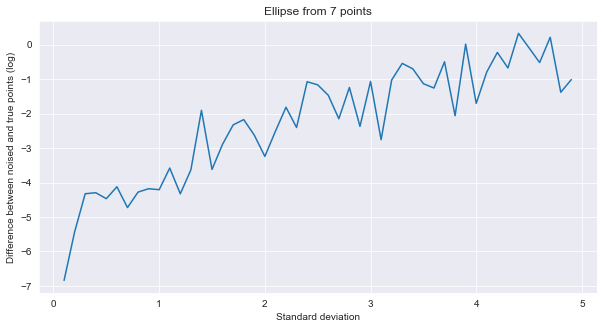

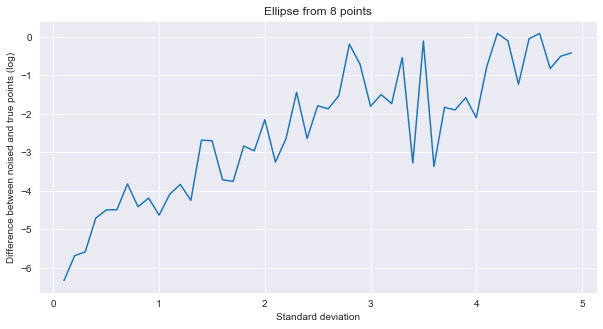

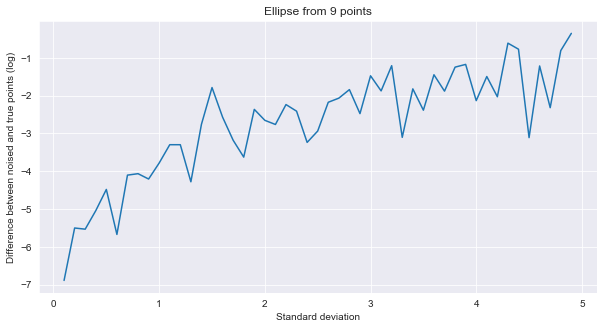

In [51]:
for i, difference in enumerate(differences):
    fig, ax = plt.subplots(figsize=(10, 5))
    _ = sb.lineplot(np.arange(0, 5, 0.1), difference)
    _ = ax.set_title('Ellipse from {} points'.format(i + 5))
    _ = ax.set_ylabel('Difference between noised and true points (log)')
    _ = ax.set_xlabel('Standard deviation')

We can see that methods which rely on bigger amounts of points are better. But there is significant difference between performances based on 6 and 7 points, but there is much smaller difference between performances based on 5-6 and 7-9 points. So taking 7 points should be enough to obtain optimal results.